# Trajectory optimization of Bipedal Model

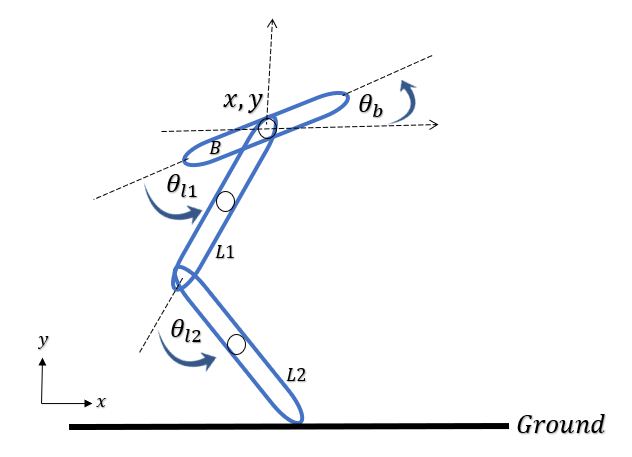

In [22]:
from IPython.display import Image
Image("model.png")

B-The body rotated relative to the inertial space
L1-Link 1 rotates relative to the body 
L2-Link 2 rotates relative to the link 1

Generlized coordinates:
q = 〖[x,y,θ_b,θ_l1,θ_l2]〗^T

In [7]:
#%reset
#DERIVE THE EOMs SYMBOLICALLY ----------------------------------------------------------------------------------------------

#import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

#create symbolic variables

#system parameters
g = sym.symbols('g')
X0,Y0 = sym.symbols(['X0','Y0']) #position of first link
mb,ml1,ml2 = sym.symbols(['m_{body}','m_{leg1}','m_{leg2}']) #mass
lb,ll1,ll2 = sym.symbols(['l_{body}','l_{leg1}','l_{leg2}']) #length
Inb,Inl1,Inl2 = sym.symbols(['I_{body}','I_{leg1}','I_{leg2}']) #moment of intertia


# generalized coordinates
x,y,thb,thl1,thl2 = sym.symbols(['x','y','\\theta_{body}','\\theta_{leg1}','\\theta_{leg2}']) #position
dx,dy,dthb,dthl1,dthl2 = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{body}','\dot{\\theta}_{leg1}','\dot{\\theta}_{leg2}']) 
ddx,ddy,ddthb,ddthl1,ddthl2 = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{body}','\ddot{\\theta}_{leg1}','\ddot{\\theta}_{leg2}']) 

q = sym.Matrix([[x],[y],[thb],[thl1],[thl2]])
dq = sym.Matrix([[dx],[dy],[dthb],[dthl1],[dthl2]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb],[ddthl1],[ddthl2]])

# forces
# total joint action = actuator + rebound, but that will be dealt with elsewhere
F,tau,GRFx,GRFy = sym.symbols(['F','\\tau','G_x','G_y']) 


# STEP 1: position vectors ri = [x,y,theta] (world frame)
rb = sym.Matrix([[x],
                [y],
                [thb]])

rl1 = sym.Matrix([[x - ll1*sym.sin(thb + thl1)],
                [y - ll1*sym.cos(thb + thl1)],
                [thb + thl1]])

rl2 = sym.Matrix([[x - ll1*sym.sin(thb + thl1)-ll2*sym.sin(thb + thl1+thl2)],
                [y - ll1*sym.cos(thb + thl1)-ll2*sym.cos(thb + thl1+thl2)],
                [thb + thl1+thl2]])

# the Jacobians
Jb = rb.jacobian(q)
Jl1 = rl1.jacobian(q)
Jl2 = rl2.jacobian(q)

# STEP 2: generate expressions for the system space velocities from the jacobians
vb = Jb*dq
vl1 = Jl1*dq
vl2 = Jl2*dq

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([[mb,mb,Inb]])
Ml1 = sym.Matrix([[ml1,ml1,Inl1]])
Ml2 = sym.Matrix([[ml2,ml2,Inl2]])

T = 0.5*Mb*sym.matrix_multiply_elementwise(vb,vb) + 0.5*Ml1*sym.matrix_multiply_elementwise(vl1,vl1) + 0.5*Ml2*sym.matrix_multiply_elementwise(vl2,vl2)
T = T[0]
V = mb*g*rb[1] + ml1*g*rl1[1] + ml2*g*rl2[1]


# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# STEP 5: generalized forces

# force vectors for each link
tau_b = sym.Matrix([[0],[0],[-tau]])
tau_l1 = sym.Matrix([[0],[0],[tau]])

F_l1 = sym.Matrix([[-F*sym.sin(thb+thl1)],[F*sym.cos(thb+thl1)],[0]])
F_l2 = sym.Matrix([[F*sym.sin(thb+thl1+thl2)],[-F*sym.cos(thb+thl1+thl2)],[0]])

GRF_l2 = sym.Matrix([[GRFx],[GRFy],[ll2*GRFx*sym.cos(thb+thl1+thl2)+ll2*GRFy*sym.sin(thb+thl1+thl2)]])

Q = sym.zeros(len(q),1)
for j in range(len(q)):
    Q[j] = tau_b.transpose()*Jb[:,j]+(tau_l1+F_l1).transpose()*Jl1[:,j]+(F_l2+GRF_l2).transpose()*Jl2[:,j]

# AND combine!
EOM = Lg1 - Lg3 + Lg4 - Q

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()
    
# the simplification step is a little time-consuming so try to avoid re-running this cell if possible.

In [8]:
# Lambdify
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,ml1,ml2,lb,ll1,ll2,Inb,Inl1,Inl2,
            x,y,thb,thl1,thl2,
            dx,dy,dthb,dthl1,dthl2,
            ddx,ddy,ddthb,ddthl1,ddthl2,
            F,tau,GRFx,GRFy]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_thb = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_thl = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_r = sym.lambdify(sym_list,EOMs[4],modules = [func_map])

In [12]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N =100
m.N = RangeSet(N) 

links = [('body',1),('leg',1),('leg',2)]
m.L = Set(dimen=2, initialize = links)

DOFs = ['x','y','theta_b','theta_l1','theta_l2'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81)

def get_m(n, lb, ln):
    if lb == 'body':
        return 5.0
    else: return 2.5
m.m = Param(m.L, initialize = get_m) # mass of links

def get_len(n, lb, ln):
    if lb == 'body':
        return 1.0
    else: return 0.5
m.len = Param(m.L, initialize = get_len) # length of links

def calculate_In(m, lb, ln): 
    l = (lb,ln)
    # yes, that does mean you have to rebuild the tuple inside the function. Yes, it is dumb.
    return m.m[l]*m.len[l]**2/12 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

mbody = sum(m.m[l] for l in links)
BW = mbody*m.g.value

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# bound variables
for n in range(1,N+1):
    for l in links:
        m.q[n,'y'].setlb(0.0)


In [14]:
# TIME AND INTEGRATION

# variable timestep
hm = 0.02 # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


RuntimeError: Cannot add component 'integrate_p_index' (type <class 'pyomo.core.base.set.SetProduct_OrderedSet'>) to block 'unknown': a component by that name (type <class 'pyomo.core.base.set.SetProduct_OrderedSet'>) is already defined.

In [20]:
# GROUND INTERACTIONS -------------------------------------------------------------------------------------------------------

# paramters
m.mu = Param(initialize = 1) # friction coefficient

# sign set for positive and negative components
signs = ['ps','ng'] 
m.sgn = Set(initialize = signs)

WDOFs = ['X','Y',"THETA"] # absolute coordinates (see what I mean about switching between frames the whole time...?)
m.WDOF = Set(initialize = WDOFs) 

# variables
m.footp = Var(m.N, m.WDOF, bounds = (0.0,None)) # foot position
m.footv = Var(m.N, m.WDOF, m.sgn, bounds = (0.0,None)) # foot velocity

m.friction_cone = Var(m.N, bounds = (0.0,None))

m.GRF = Var(m.N, m.WDOF, m.sgn, bounds = (0.0,None)) # ground reaction forces

ground_constraints = ['contact','friction','slip_ps','slip_ng'] 
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties
m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))

# constraints: aux variables
def def_footp(m,n,dof):
    if dof == 'Y':
        L = 0.5*m.len[('leg',1)] + m.q[n,'r'] + 0.5*m.len[('leg',2)] # total leg length
        thA = m.q[n,'theta_b'] + m.q[n,'theta_l1']+m.q[n,'theta_l2'] # absolute leg angle
        return m.footp[n,dof] == m.q[n,'y'] - L*cos(thA)
    else:
        return Constraint.Skip
m.def_footp = Constraint(m.N, m.WDOF, rule = def_footp)




# lambdify the foot velocity
footx = sym.Matrix([x - ll1*sym.sin(thb + thl1)-ll2*sym.sin(thb + thl1+thl2)])
footdx = footx.jacobian(q)*dq
footdx = footdx[0].simplify()
lamb_footdx = sym.lambdify(sym_list,footdx,modules = [func_map])

def def_footv(m,n,dof):
    if dof == 'X':
        var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_l1'],m.q[n,'theta_l2'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_l1'],m.dq[n,'theta_l2'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_l1'],m.ddq[n,'theta_l2'],
            0,0,0,0]
        return m.footv[n,dof,'ps']-m.footv[n,dof,'ng'] == lamb_footdx(*var_list)
    else:
        return Constraint.Skip
m.def_footv = Constraint(m.N, m.WDOF, rule = def_footv)

def def_friction_cone(m,n):
    return m.friction_cone[n] == m.mu*m.GRF[n,'Y','ps'] - (m.GRF[n,'X','ps'] + m.GRF[n,'X','ng'])
m.def_friction_cone = Constraint(m.N, rule = def_friction_cone)

# constraints: complementarity

# contact
def ground_contact(m,n):
    if n < N:
        return m.ground_penalty[n,'contact'] == m.footp[n+1,'Y']*m.GRF[n,'Y','ps'] 
    else:
        return Constraint.Skip
m.ground_contact = Constraint(m.N, rule = ground_contact)

# friction
def ground_friction(m,n):
    return m.ground_penalty[n,'friction'] == (m.footv[n,'X','ps']+m.footv[n,'X','ng'])*m.friction_cone[n]
m.ground_friction = Constraint(m.N, rule = ground_friction)

# slipping
def ground_slip_ps(m,n):
    return m.ground_penalty[n,'slip_ps'] == m.footv[n,'X','ps']*m.GRF[n,'X','ps']
m.ground_slip_ps = Constraint(m.N, rule = ground_slip_ps)

def ground_slip_ng(m,n):
    return m.ground_penalty[n,'slip_ng'] == m.footv[n,'X','ng']*m.GRF[n,'X','ng']
m.ground_slip_ng = Constraint(m.N, rule = ground_slip_ng)

# bound contact forces at last node
for dof in WDOFs:
    for sgn in signs:
        m.GRF[N,dof,sgn].value = 0
        m.GRF[N,dof,sgn].fixed = True

    'pyomo.core.base.param.SimpleParam'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.param.SimpleParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.set.OrderedSimpleSet'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.set.AbstractOrderedSimpleSet'>).
    This is usually indicative of a modelling error. To avoid this warning,
    use block.del_component() and block.add_component().
    'pyomo.core.base.set.OrderedSimpleSet'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.set.AbstractOrderedSimpleSet'>).
    This is usually indicative of a modelling error. To avoid this warning,
    use block.del_component() and block.add_component().


RuntimeError: Cannot add component 'footp_index' (type <class 'pyomo.core.base.set.SetProduct_OrderedSet'>) to block 'unknown': a component by that name (type <class 'pyomo.core.base.set.SetProduct_OrderedSet'>) is already defined.

In [18]:
# HARD JOINT STOPS ----------------------------------------------------------------------------------------------------------

# sets
joints = ['hip','knee']
m.J = Set(initialize = joints)

joint_constraints = ['up','lo'] # set of joint penalties
m.joint_constraints = Set(initialize = joint_constraints)

# parameters
hip_bound = [-np.pi/2,np.pi/2]
m.hip_bound = Param(m.joint_constraints, initialize = {'up':hip_bound[1],'lo':hip_bound[0]}) 

knee_bound = [0.0,0.5]
m.knee_bound = Param(m.joint_constraints, initialize = {'up':knee_bound[1],'lo':knee_bound[0]})

# we can bound the joint coordinates directly
for n in range(1,N+1):
    m.q[n,'theta_l1'].setlb(hip_bound[0])
    m.q[n,'theta_l1'].setub(hip_bound[1])
    m.q[n,'theta_l2'].setlb(knee_bound[0])
    m.q[n,'theta_l2'].setub(knee_bound[1])

# variables
m.tau_a = Var(m.N, bounds = (-2,2)) # actuator torque at hip
m.tau_r = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound torque

m.F_a = Var(m.N, bounds = (-3,3)) # actuator force at knee
m.F_r = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound force (acts parallel to the leg)

m.joint_penalty = Var(m.N, m.J, m.joint_constraints, bounds = (0.0,None))

# complementarity
def hip_limits(m,n,jc):
    if n < N:
        if jc == 'up':
            # NEXT angle
            return m.joint_penalty[n,'hip',jc] == (m.hip_bound['up'] - m.q[n+1,'theta_l1'])*m.tau_r[n,'ng']
        else:
            return m.joint_penalty[n,'hip',jc] == (m.q[n+1,'theta_l1'] - m.hip_bound['lo'])*m.tau_r[n,'ps']
    else:
        return Constraint.Skip
m.hip_limits = Constraint(m.N, m.joint_constraints, rule = hip_limits)

def knee_limits(m,n,jc):
    if n < N:
        if jc == 'up':
            # NEXT distance
            return m.joint_penalty[n,'knee',jc] == (m.knee_bound['up'] - m.q[n+1,'r'])*m.F_r[n,'ng']
        else:
            return m.joint_penalty[n,'knee',jc] == (m.q[n+1,'theta_l2'] - m.knee_bound['lo'])*m.F_r[n,'ps']
    else:
        return Constraint.Skip
m.knee_limits = Constraint(m.N, m.joint_constraints, rule = knee_limits)

# bound contact forces at last node
for sgn in signs:
    m.F_r[N,sgn].value = 0
    m.F_r[N,sgn].fixed = True

for sgn in signs:
    m.tau_r[N,sgn].value = 0
    m.tau_r[N,sgn].fixed = True

    'pyomo.core.base.set.OrderedSimpleSet'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.set.AbstractOrderedSimpleSet'>).
    This is usually indicative of a modelling error. To avoid this warning,
    use block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.set.OrderedSimpleSet'>) on block unknown
    with a new Component (type=<class
    'pyomo.core.base.set.AbstractOrderedSimpleSet'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.IndexedParam'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.param.IndexedParam'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    'pyomo.core.base.param.IndexedParam'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.param.IndexedParam'>). This is


RuntimeError: Cannot add component 'tau_r_index' (type <class 'pyomo.core.base.set.SetProduct_OrderedSet'>) to block 'unknown': a component by that name (type <class 'pyomo.core.base.set.SetProduct_OrderedSet'>) is already defined.

In [66]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------

# minimum time

def CostFun(m):
    T = sum(m.h[n] for n in range(1,N+1))
    penalty_sum = 0
    for n in range(1,N+1):
        for gc in ground_constraints:
            penalty_sum += m.ground_penalty[n,gc]
        for jc in joint_constraints:
            for j in joints:
                penalty_sum += m.joint_penalty[n,j,jc]
    return T+1000*penalty_sum
m.Cost = Objective(rule = CostFun)

In [67]:
# EQUATIONS OF MOTION -------------------------------------------------------------------------------------------------------
S = BW

def EOM_x(m,n):
    F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_in = S*(m.tau_a[n] + m.tau_r[n,'ps'] - m.tau_r[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_l'],m.q[n,'r'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_l'],m.dq[n,'r'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_l'],m.ddq[n,'r'],
            F_in,tau_in,Gx_in,Gy_in]
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, rule = EOM_x)

def EOM_y(m,n):
    F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_in = S*(m.tau_a[n] + m.tau_r[n,'ps'] - m.tau_r[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_l'],m.q[n,'r'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_l'],m.dq[n,'r'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_l'],m.ddq[n,'r'],
            F_in,tau_in,Gx_in,Gy_in]
    return lambEOM_y(*var_list) == 0
m.EOM_y = Constraint(m.N, rule = EOM_y)

def EOM_thb(m,n):
    F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_in = S*(m.tau_a[n] + m.tau_r[n,'ps'] - m.tau_r[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_l'],m.q[n,'r'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_l'],m.dq[n,'r'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_l'],m.ddq[n,'r'],
            F_in,tau_in,Gx_in,Gy_in]
    return lambEOM_thb(*var_list) == 0
m.EOM_thb = Constraint(m.N, rule = EOM_thb)

def EOM_thl(m,n):
    F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_in = S*(m.tau_a[n] + m.tau_r[n,'ps'] - m.tau_r[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_l'],m.q[n,'r'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_l'],m.dq[n,'r'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_l'],m.ddq[n,'r'],
            F_in,tau_in,Gx_in,Gy_in]
    return lambEOM_thl(*var_list) == 0
m.EOM_thl = Constraint(m.N, rule = EOM_thl)

def EOM_r(m,n):
    F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    tau_in = S*(m.tau_a[n] + m.tau_r[n,'ps'] - m.tau_r[n,'ng'])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_l'],m.q[n,'r'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_l'],m.dq[n,'r'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_l'],m.ddq[n,'r'],
            F_in,tau_in,Gx_in,Gy_in]
    return lambEOM_r(*var_list) == 0
m.EOM_r = Constraint(m.N, rule = EOM_r)

In [68]:
# # HIGH DROP -----------------------------------------------------------------------------------------------------------------

# # initial condition
# m.q[1,'x'].value = 0.0
# m.q[1,'y'].value = 3.0
# m.q[1,'theta_b'].value = 0.0
# m.q[1,'theta_l'].value = 0.0
# m.q[1,'r'].value = 0.25

# for dof in DOFs:
#     m.q[1,dof].fixed = True
#     m.dq[1,dof].value = 0.0
#     m.dq[1,dof].fixed = True
    
# for n in range(1,N+1):
#     m.F_a[n].value = 0.0
#     m.F_a[n].fixed = True
#     m.tau_a[n].value = 0.0
#     m.tau_a[n].fixed = True
    
# #m.pprint()

# # LOW DROP ------------------------------------------------------------------------------------------------------------------

# # initial condition
# m.q[1,'x'].value = 0.0
# m.q[1,'theta_b'].value = 0.0
# m.q[1,'theta_l'].value = 0.0
# m.q[1,'r'].value = 0.25

# m.footp[1,'Y'].value = 0.1
# m.footp[1,'Y'].fixed = True

# for dof in DOFs:
#     if dof != 'y':
#         m.q[1,dof].fixed = True
#     m.dq[1,dof].value = 0.0
#     m.dq[1,dof].fixed = True
    
# for n in range(1,N+1):
#     m.F_a[n].value = 0.0
#     m.F_a[n].fixed = True
#     m.tau_a[n].value = 0.0
#     m.tau_a[n].fixed = True
    
# #m.pprint()

# # STANDING ------------------------------------------------------------------------------------------------------------------

# # initial condition
# m.q[1,'x'].value = 0.0
# m.q[1,'theta_b'].value = 0.0
# m.q[1,'theta_l'].value = 0.0
# m.q[1,'r'].value = 0.25

# m.footp[1,'Y'].value = 0.0
# m.footp[1,'Y'].fixed = True

# for dof in DOFs:
#     if dof != 'y':
#         m.q[1,dof].fixed = True
#     m.dq[1,dof].value = 0.0
#     m.dq[1,dof].fixed = True
    
# for n in range(1,N+1):
#     m.F_a[n].value = 0.0
#     m.F_a[n].fixed = True
#     m.tau_a[n].value = 0.0
#     m.tau_a[n].fixed = True
    
# #m.pprint()

# # HOP -----------------------------------------------------------------------------------------------------------------------

# # initial condition
# m.q[1,'x'].value = 0.0
# m.q[1,'theta_b'].value = 0.0
# m.q[1,'theta_l'].value = 0.0
# m.q[1,'r'].value = 0.25

# m.footp[1,'Y'].value = 0.0
# m.footp[1,'Y'].fixed = True

# for dof in DOFs:
#     if dof != 'y':
#         m.q[1,dof].fixed = True
#     m.dq[1,dof].value = 0.0
#     m.dq[1,dof].fixed = True
    
# # final condition
# m.q[N,'y'].setlb(1.2)
    
# #m.pprint()

In [69]:
# INITIALIZE ----------------------------------------------------------------------------------------------------------------
guide = np.linspace(0,5.0,N)
for n in range(1,N+1):
    m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
    m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
    m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
    m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
    m.q[n,'r'].value  = np.random.uniform(0.0,0.5)
    
    m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
    m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value

In [70]:
# SPRINT --------------------------------------------------------------------------------------------------------------------
# tax day

# initial condition
m.q[1,'x'].value = 0.0
m.q[1,'theta_b'].value = 0.0
m.q[1,'theta_l'].value = 0.0

m.q[1,'x'].fixed = True
m.q[1,'theta_b'].fixed = True
m.q[1,'theta_l'].fixed = True

m.footp[1,'Y'].value = 0.0
m.footp[1,'Y'].fixed = True

for dof in DOFs:
    m.dq[1,dof].value = 0.0
    m.dq[1,dof].fixed = True
      
# final condition
m.q[N,'x'].setlb(5.0)

m.dq[N,'x'].value = 0.0
m.dq[N,'x'].fixed = 0.0
m.dq[N,'theta_b'].value = 0.0
m.dq[N,'theta_b'].fixed = 0.0
m.dq[N,'theta_l'].value = 0.0
m.dq[N,'theta_l'].fixed = 0.0

m.q[N,'theta_b'].value = 0.0
m.q[N,'theta_l'].value = 0.0
m.q[N,'theta_b'].fixed = True
m.q[N,'theta_l'].fixed = True

m.footp[N,'Y'].value = 0.0
m.footp[N,'Y'].fixed = True
    
#m.pprint()

In [71]:
# solving------------------------------------------------------------------------------------------------------------
#opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
from pyomo.opt import SolverFactory
opt = SolverFactory('ipopt',executable = 'C:/cygwin64/home/Yousuf/CoinIpopt/build/bin/ipopt.exe')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000 # maximum number of iterations
opt.options["max_cpu_time"] = 600 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee = True) 

Ipopt 3.12.12: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:     7291
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3012

Total number of variables............................:     1831
                     variables with only lower bounds:      992
                variables with lower and upper bounds:      248
                     variables with only 

  78  4.5963539e+04 3.99e+01 1.77e+03  -1.0 7.92e+01  -0.4 3.37e-02 3.75e-02h  1
  79  4.6225925e+04 3.95e+01 2.46e+03  -1.0 2.53e+01   0.1 3.30e-02 8.49e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  4.6887317e+04 3.89e+01 2.59e+03  -1.0 2.01e+01   0.5 1.91e-02 1.67e-02h  1
  81  4.8700261e+04 3.63e+01 1.33e+03  -1.0 3.09e+01   0.0 2.17e-03 6.21e-02h  1
  82  4.9541318e+04 3.55e+01 1.62e+03  -1.0 2.13e+01   0.4 2.96e-02 2.38e-02h  1
  83  4.9943479e+04 3.48e+01 1.85e+03  -1.0 2.86e+01  -0.0 3.65e-02 1.96e-02h  1
  84  5.0407500e+04 3.43e+01 1.82e+03  -1.0 1.82e+01   0.4 9.90e-03 1.43e-02h  1
  85  5.2108769e+04 3.01e+01 1.61e+03  -1.0 2.83e+01  -0.1 1.07e-01 1.13e-01h  1
  86  5.3613047e+04 2.80e+01 1.50e+03  -1.0 1.64e+01   0.3 2.25e-02 6.65e-02h  1
  87  5.3284289e+04 2.62e+01 1.41e+03  -1.0 4.74e+01  -0.2 1.06e-01 6.13e-02f  1
  88  5.4584726e+04 2.37e+01 1.28e+03  -1.0 1.69e+01   0.3 1.29e-01 9.31e-02h  1
  89  5.3880065e+04 2.32e+01

 174  7.7623919e+03 2.61e-02 3.66e+05  -3.8 3.21e-01   0.8 9.91e-01 1.83e-01f  1
 175  7.7155577e+03 1.99e-02 2.53e+05  -3.8 9.70e-01   0.3 4.17e-01 3.46e-01f  1
 176  7.6333075e+03 2.32e-02 5.62e+05  -3.8 3.00e+00  -0.2 8.26e-01 2.28e-01f  1
 177  7.4199475e+03 6.02e-02 6.61e+05  -3.8 9.30e+00  -0.6 5.36e-01 2.11e-01f  1
 178  7.3878031e+03 5.64e-02 4.97e+05  -3.8 3.15e+00  -0.2 2.62e-02 8.47e-02f  1
 179  7.3633155e+03 5.51e-02 1.68e+06  -3.8 9.46e+00  -0.7 4.02e-01 2.32e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  7.2385383e+03 6.04e-02 1.62e+06  -3.8 2.71e+01  -1.2 6.82e-02 4.01e-02f  1
 181  7.2377529e+03 6.01e-02 1.69e+06  -3.8 1.32e+00   0.2 5.38e-02 4.84e-03f  1
 182  7.1568972e+03 5.03e-02 1.46e+06  -3.8 3.95e+00  -0.3 4.37e-01 1.77e-01f  1
 183  7.0717153e+03 5.09e-02 1.81e+07  -3.8 1.17e+01  -0.8 1.11e-02 6.57e-02f  1
 184  6.9710447e+03 7.01e-02 1.77e+07  -3.8 6.08e+01  -1.3 1.80e-03 2.18e-02f  1
 185  6.9277605e+03 6.93e-02

 276  4.6973292e+03 8.61e-02 2.70e+02  -3.8 3.05e+00  -0.7 4.87e-01 6.27e-02f  1
 277  4.6796384e+03 9.52e-02 3.03e+02  -3.8 1.02e+01  -1.2 1.10e-01 3.81e-02f  1
 278  4.6602784e+03 9.23e-02 5.61e+02  -3.8 3.45e+00  -0.8 4.55e-01 1.22e-01f  1
 279  4.6365275e+03 1.24e-01 5.27e+02  -3.8 1.27e+01  -1.3 3.84e-04 4.46e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  4.6166164e+03 1.27e-01 7.39e+02  -3.8 4.04e+00  -0.8 8.07e-01 1.10e-01f  1
 281  4.5744250e+03 2.51e-01 7.00e+02  -3.8 1.59e+01  -1.3 4.01e-02 6.32e-02f  1
 282  4.5594990e+03 2.44e-01 6.56e+02  -3.8 4.73e+00  -0.9 5.75e-02 6.90e-02f  1
 283  4.4980275e+03 1.98e-01 2.27e+02  -3.8 1.69e+00  -0.5 1.00e+00 7.71e-01f  1
 284  4.4685561e+03 3.88e-02 1.14e+03  -3.8 6.30e-01  -0.0 2.10e-01 9.63e-01f  1
 285  4.4569539e+03 5.11e-03 5.91e-01  -3.8 2.36e-01   0.4 1.00e+00 1.00e+00f  1
 286  4.4525358e+03 7.36e-04 5.92e-01  -3.8 8.88e-02   0.8 1.00e+00 1.00e+00f  1
 287  4.4389914e+03 7.23e-03

 376  2.4756055e+03 2.40e-01 1.56e+03  -3.8 3.00e+03  -2.4 1.35e-03 1.01e-03f  1
 377  2.4755809e+03 2.39e-01 1.56e+03  -3.8 3.07e+00  -1.1 3.64e-04 3.49e-04h  1
 378  2.4747206e+03 2.38e-01 1.56e+03  -3.8 9.43e+00  -1.5 1.00e-02 4.39e-03f  1
 379  2.3286927e+03 7.49e-01 7.36e+02  -3.8 3.55e+01  -2.0 7.11e-02 2.56e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380  2.3286637e+03 7.48e-01 1.22e+03  -3.8 1.34e+00  -0.7 2.82e-01 1.07e-03h  1
 381  2.3267530e+03 7.25e-01 1.12e+03  -3.8 3.99e+00  -1.2 1.50e-02 3.08e-02h  1
 382  2.3179056e+03 3.45e-01 9.26e+02  -3.8 1.49e+00  -0.7 1.54e-01 5.45e-01f  1
 383  2.3155825e+03 2.25e-01 4.91e+02  -3.8 3.90e-01  -0.3 5.64e-01 3.50e-01h  1
 384  2.3146761e+03 1.43e-01 2.30e+02  -3.8 1.55e-01   0.1 2.30e-01 3.64e-01h  1
 385  2.3110098e+03 6.75e-02 9.76e+02  -3.8 4.52e-01  -0.4 3.50e-01 5.46e-01h  1
 386  2.3051941e+03 5.29e-02 7.13e+02  -3.8 1.36e+00  -0.8 3.03e-01 3.12e-01f  1
 387  2.2981260e+03 5.50e-02

 478  1.5068464e+03 6.82e-02 2.71e+01  -3.8 1.86e+01  -2.3 3.35e-01 3.31e-01f  1
 479  1.4707226e+03 2.35e-01 9.92e+02  -3.8 5.49e+01  -2.8 1.26e-01 2.54e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480  1.4627261e+03 2.18e-01 1.05e+03  -3.8 2.34e+01  -2.3 2.73e-01 1.03e-01f  1
 481  1.4589358e+03 1.87e-01 7.23e+02  -3.8 8.43e+00  -1.9 3.46e-01 1.51e-01h  1
 482  1.4488923e+03 1.82e-01 6.70e+02  -3.8 3.37e+01  -2.4 6.51e-02 8.04e-02f  1
 483  1.4488322e+03 1.82e-01 6.55e+02  -3.8 6.14e+01  -2.9 3.08e-02 4.02e-04h  1
 484  1.4377518e+03 1.80e-02 1.11e+03  -3.8 3.62e+00  -1.5 5.47e-02 1.00e+00f  1
 485  1.4369026e+03 3.39e-02 1.10e+03  -3.8 6.21e+01  -2.0 5.44e-03 1.87e-02f  1
 486  1.4360023e+03 3.11e-02 6.22e+02  -3.8 3.96e+00  -1.6 3.78e-01 8.68e-02f  1
 487  1.4325803e+03 9.07e-03 7.94e+02  -3.8 1.53e+00  -1.2 3.42e-01 8.46e-01h  1
 488  1.4233978e+03 6.63e-02 2.53e+02  -3.8 4.37e+00  -1.6 5.80e-01 7.69e-01f  1
 489  1.4199491e+03 2.96e-02

 576  6.0563021e+02 6.48e-07 1.05e+00  -3.8 1.58e-02   0.6 1.00e+00 1.00e+00f  1
 577  6.0555003e+02 9.63e-07 1.94e+03  -3.8 5.02e-02   0.2 1.00e+00 5.88e-01f  1
 578  6.0536717e+02 3.77e-06 6.76e+02  -3.8 1.63e-01  -0.3 8.53e-01 5.80e-01f  1
 579  6.0462160e+02 1.37e-04 1.98e+03  -3.8 4.83e-01  -0.8 4.73e-01 9.06e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580  6.0211761e+02 1.82e-03 1.76e+03  -3.8 1.48e+00  -1.3 5.25e-01 1.00e+00f  1
 581  5.9848206e+02 7.16e-03 1.33e+03  -3.8 4.34e+00  -1.8 2.48e-01 4.90e-01f  1
 582  5.9280204e+02 3.84e-02 8.11e+02  -3.8 1.30e+01  -2.2 3.70e-01 2.53e-01f  1
 583  5.8251465e+02 2.67e-01 8.17e+02  -3.8 4.36e+01  -2.7 7.53e-02 1.40e-01f  1
 584  5.6860406e+02 3.40e-01 1.03e+03  -3.8 1.48e+01  -2.3 4.25e-02 5.44e-01f  1
 585  5.5558212e+02 7.56e-01 6.54e+02  -3.8 5.31e+01  -2.8 2.92e-01 1.36e-01f  1
 586  5.5114911e+02 1.52e-02 5.96e+01  -3.8 2.16e+00  -1.4 1.00e+00 1.00e+00h  1
 587  5.3915357e+02 1.69e-01

 678  2.0097028e+02 1.89e-03 2.19e+01  -3.8 1.34e+00  -1.8 8.41e-01 1.00e+00f  1
 679  2.0064033e+02 2.75e-04 4.72e-01  -3.8 4.98e-01  -1.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 680  2.0033124e+02 4.43e-04 8.75e+01  -3.8 1.46e+00  -1.8 8.01e-01 3.12e-01h  1
 681  1.9754226e+02 2.12e-02 6.30e-01  -3.8 4.14e+00  -2.3 1.00e+00 1.00e+00f  1
 682  1.9474514e+02 3.73e-02 6.16e+01  -3.8 1.02e+01  -2.8 3.63e-01 3.91e-01h  1
 683  1.9300011e+02 4.37e-02 6.25e+03  -3.8 2.13e+01  -3.3 9.92e-01 9.99e-02h  1
 684  1.8868002e+02 9.63e-02 5.55e+03  -3.8 5.61e+01  -3.7 9.73e-02 1.04e-01f  1
 685  1.8632939e+02 2.24e-02 6.29e-01  -3.8 3.99e+00  -2.4 1.00e+00 1.00e+00h  1
 686  1.8349415e+02 4.53e-02 7.77e+02  -3.8 9.45e+00  -2.9 2.97e-01 4.39e-01h  1
 687  1.8236182e+02 4.70e-02 6.98e+02  -3.8 2.14e+01  -3.4 8.11e-02 6.92e-02h  1
 688  1.7914398e+02 7.30e-02 6.32e+02  -3.8 6.85e+01  -3.8 7.60e-02 7.24e-02f  1
 689  1.7545903e+02 1.02e-01

 782  6.6377711e+01 4.43e-01 1.75e+03  -3.8 2.19e+00  -2.6 4.25e-04 5.56e-04h  1
 783  6.6377711e+01 4.43e-01 1.75e+03  -3.8 3.02e+02  -3.1 5.19e-07 4.14e-07h  2
 784  6.6377722e+01 4.43e-01 1.75e+03  -3.8 3.38e+01   0.0 2.61e-04 1.94e-06f  2
 785  6.6417023e+01 2.30e-01 9.42e+02  -3.8 3.85e-01  -0.5 5.21e-01 4.81e-01h  1
 786  6.6426934e+01 1.17e-01 1.38e+03  -3.8 1.39e-01  -0.9 9.81e-01 4.91e-01h  1
 787  6.6392909e+01 5.37e-03 9.36e+01  -3.8 1.70e-01  -1.4 8.53e-01 9.54e-01h  1
 788  6.6320988e+01 3.79e-04 1.58e-01  -3.8 2.31e-01  -1.9 1.00e+00 1.00e+00f  1
 789  6.6116674e+01 2.67e-03 3.49e-02  -3.8 7.12e-01  -2.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 790  6.5505860e+01 2.33e-02 1.25e-01  -3.8 2.24e+00  -2.8 1.00e+00 1.00e+00h  1
 791  6.4837851e+01 4.80e-02 2.92e+02  -3.8 7.82e+00  -3.3 5.65e-01 3.50e-01h  1
 792  6.4871760e+01 1.76e-02 1.01e+03  -3.8 5.69e-01  -2.0 4.05e-01 7.08e-01h  1
 793  6.4808274e+01 1.25e-02

 884  5.3591164e+01 9.26e-02 5.63e+00  -5.7 3.56e+01  -5.2 2.22e-01 1.64e-01h  1
 885  5.3524826e+01 9.86e-02 5.65e+00  -5.7 1.30e+01  -4.8 1.00e+00 3.42e-01h  1
 886  5.3488337e+01 9.66e-02 1.19e+01  -5.7 3.87e+01  -5.3 4.19e-01 6.55e-02h  1
 887  5.3313629e+01 2.52e-01 2.09e+00  -5.7 1.01e+01  -4.9 5.57e-01 1.00e+00h  1
 888  5.3226794e+01 2.23e-01 4.80e+00  -5.7 3.61e+01  -5.3 2.94e-01 1.64e-01h  1
 889  5.3223778e+01 1.95e-01 5.40e+01  -5.7 1.47e+00  -4.0 5.32e-02 1.28e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890  5.3220759e+01 1.86e-01 5.13e+01  -5.7 4.48e+00  -4.5 1.97e-03 4.20e-02h  1
 891  5.3218231e+01 1.84e-01 5.07e+01  -5.7 1.39e+01  -5.0 1.17e-02 1.16e-02h  1
 892  5.3210346e+01 1.82e-01 5.02e+01  -5.7 1.85e+02  -5.5 1.08e-02 1.08e-02f  1
 893  5.3089150e+01 1.50e-01 9.01e+01  -5.7 1.59e+01  -5.0 8.11e-01 5.05e-01h  1
 894  5.3085657e+01 1.05e-01 2.12e+01  -5.7 2.60e-01  -2.8 8.53e-01 2.97e-01h  1
 895  5.3081272e+01 1.60e-04

 983  5.0257876e+01 3.37e-02 9.71e-01  -5.7 4.29e+00  -4.6 4.01e-01 1.00e+00h  1
 984  5.0243749e+01 7.40e-03 4.65e-02  -5.7 1.64e+00  -4.2 1.00e+00 9.34e-01h  1
 985  5.0199300e+01 2.92e-01 1.16e+00  -5.7 5.12e+00  -4.7 5.47e-01 9.54e-01f  1
 986  5.0123101e+01 1.62e-01 1.44e+00  -5.7 1.54e+01  -5.1 4.00e-01 5.50e-01h  1
 987  5.0100734e+01 1.61e-01 1.50e+00  -5.7 6.97e+01  -5.6 4.89e-02 3.93e-02h  1
 988  5.0037357e+01 1.61e-01 1.92e+01  -5.7 1.95e+01  -5.2 1.00e+00 3.67e-01h  1
 989  5.0009938e+01 1.65e-01 1.91e+01  -5.7 9.94e+01  -5.7 2.85e-02 3.34e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 990  4.9958088e+01 1.65e-01 3.89e+01  -5.7 2.45e+01  -5.2 1.17e-01 2.32e-01h  1
 991  4.9957977e+01 1.64e-01 3.86e+01  -5.7 5.78e-01  -1.2 4.35e-03 5.83e-03h  1
 992  4.9957946e+01 1.62e-01 3.81e+01  -5.7 9.53e-02  -1.7 2.87e-03 1.01e-02h  1
 993  4.9957942e+01 1.62e-01 3.81e+01  -5.7 3.33e-01  -2.2 1.39e-04 1.32e-03h  1
 994  4.9957942e+01 1.62e-01

1082  4.8397720e+01 5.78e-03 4.98e-02  -5.7 1.34e+00  -4.0 1.00e+00 1.00e+00f  1
1083  4.8342584e+01 6.12e-02 2.30e-02  -5.7 4.09e+00  -4.5 1.00e+00 1.00e+00h  1
1084  4.8314373e+01 7.80e-02 5.57e+00  -5.7 1.31e+01  -4.9 3.68e-01 1.60e-01h  1
1085  4.8314244e+01 6.03e-02 2.29e+01  -5.7 3.21e-02  -1.8 4.38e-01 2.27e-01h  1
1086  4.8313561e+01 7.86e-06 3.88e-02  -5.7 3.03e-02  -2.3 1.00e+00 1.00e+00h  1
1087  4.8312579e+01 2.28e-05 1.00e+01  -5.7 8.33e-02  -2.8 1.00e+00 8.05e-01h  1
1088  4.8309267e+01 2.21e-04 1.99e-03  -5.7 2.45e-01  -3.2 1.00e+00 1.00e+00f  1
1089  4.8299186e+01 2.25e-03 9.86e-04  -5.7 7.39e-01  -3.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1090  4.8288943e+01 4.03e-03 1.59e+01  -5.7 2.25e+00  -4.2 6.63e-01 3.37e-01h  1
1091  4.8287799e+01 5.98e-04 1.99e+00  -5.7 1.13e-01  -2.9 1.00e+00 8.67e-01f  1
1092  4.8283570e+01 4.18e-04 3.51e-03  -5.7 3.20e-01  -3.3 1.00e+00 1.00e+00f  1
1093  4.8270918e+01 4.06e-03

1178  4.7582616e+01 1.72e-01 3.51e+01  -5.7 5.65e+00  -1.9 2.56e-06 1.94e-06f  2
1179  4.7582616e+01 1.72e-01 3.51e+01  -5.7 1.14e+00  -0.6 1.98e-06 4.80e-06h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180  4.7582586e+01 1.68e-01 4.65e+01  -5.7 1.77e-01  -0.2 5.08e-05 1.86e-02h  1
1181  4.7582509e+01 1.61e-01 4.55e+01  -5.7 8.70e-02   0.3 5.29e-02 4.64e-02h  1
1182  4.7582481e+01 1.57e-01 6.15e+01  -5.7 8.39e-02   0.7 1.15e-01 2.42e-02h  1
1183  4.7582581e+01 1.48e-01 9.37e+01  -5.7 8.97e-02   0.2 1.73e-01 5.49e-02h  1
1184  4.7582633e+01 1.17e-01 8.12e+01  -5.7 9.37e-02  -0.3 8.02e-04 2.11e-01h  1
1185  4.7582667e+01 1.11e-01 1.20e+02  -5.7 7.28e-02   0.2 2.49e-01 5.28e-02h  1
1186  4.7582941e+01 6.90e-02 7.70e+01  -5.7 7.29e-02  -0.3 3.49e-03 3.77e-01h  1
1187  4.7582514e+01 3.91e-02 4.49e+01  -5.7 4.53e-02  -0.8 3.51e-01 4.34e-01h  1
1188  4.7582050e+01 3.30e-02 3.37e+01  -5.7 2.75e-02  -1.3 3.59e-01 1.55e-01h  1
1189  4.7581724e+01 2.34e-02

1279  4.5731324e+01 1.41e-01 6.94e+01  -5.7 8.30e-02  -0.4 5.77e-01 3.36e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1280  4.5731695e+01 1.01e-01 6.61e+01  -5.7 1.90e-02  -0.9 3.55e-02 2.84e-01h  1
1281  4.5730507e+01 9.54e-02 9.98e+01  -5.7 6.30e-02  -1.4 3.86e-01 5.22e-02h  1
1282  4.5730138e+01 9.02e-02 9.58e+01  -5.7 1.11e-01  -1.9 4.31e-02 5.48e-02h  1
1283  4.5729348e+01 8.14e-02 9.02e+01  -5.7 9.16e-02  -2.4 4.90e-02 9.77e-02h  1
1284  4.5728930e+01 6.31e-02 7.39e+01  -5.7 3.82e-02  -1.9 1.34e-01 2.25e-01h  1
1285  4.5729000e+01 3.29e-02 4.40e+01  -5.7 7.05e-03  -0.6 4.12e-01 4.78e-01f  1
1286  4.5728880e+01 1.51e-06 6.67e+00  -5.7 6.19e-03  -1.1 8.66e-01 1.00e+00f  1
1287  4.5728422e+01 3.68e-06 2.05e+02  -5.7 2.28e-02  -1.6 3.13e-01 1.00e+00h  1
1288  4.5727584e+01 9.71e-06 9.59e+01  -5.7 5.45e-02  -2.0 6.03e-01 5.39e-01h  1
1289  4.5725583e+01 6.52e-05 3.29e+01  -5.7 1.29e-01  -2.5 8.37e-01 6.81e-01f  1
iter    objective    inf_pr 

1374  4.4426332e+01 7.10e-02 1.42e+01  -5.7 6.30e+01  -5.8 6.49e-01 1.56e-02h  1
1375  4.4332394e+01 2.66e-01 5.11e+00  -5.7 1.84e+02  -6.3 1.78e-01 9.20e-02h  1
1376  4.4197884e+01 6.55e-01 4.81e+00  -5.7 5.02e+02  -6.8 5.47e-02 5.59e-02h  1
1377  4.4197872e+01 6.46e-01 4.69e+00  -5.7 6.43e-02   1.0 2.32e-02 1.30e-02h  1
1378  4.4197901e+01 6.38e-01 1.42e+01  -5.7 6.68e-02   0.6 2.91e-02 1.20e-02h  1
1379  4.4198356e+01 5.81e-01 3.33e+01  -5.7 6.98e-02   0.1 1.12e-02 8.99e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1380  4.4198627e+01 5.48e-01 3.84e+01  -5.7 6.48e-02  -0.4 1.17e-01 5.75e-02h  1
1381  4.4199174e+01 4.94e-01 3.54e+01  -5.7 6.14e-02  -0.9 2.28e-01 9.75e-02h  1
1382  4.4199764e+01 4.39e-01 2.98e+01  -5.7 5.47e-02  -0.4 5.77e-02 1.12e-01h  1
1383  4.4200826e+01 3.34e-01 2.27e+01  -5.7 5.15e-02  -0.9 2.52e-01 2.38e-01h  1
1384  4.4201632e+01 2.39e-01 1.60e+01  -5.7 4.82e-02  -1.4 3.25e-01 2.87e-01h  1
1385  4.4201916e+01 8.01e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1470  4.3581876e+01 4.21e-01 7.60e+00  -5.7 1.52e+00  -1.8 1.09e-02 1.49e-05h  1
1471  4.3581826e+01 4.06e-01 1.58e+01  -5.7 1.03e-01  -2.3 1.48e-01 3.46e-02f  1
1472  4.3581591e+01 3.17e-01 5.53e+01  -5.7 1.34e-01  -2.7 3.11e-01 2.20e-01h  1
1473  4.3580654e+01 1.12e-01 6.57e+00  -5.7 1.65e-01  -3.2 8.58e-01 6.46e-01h  1
1474  4.3580067e+01 7.33e-02 3.78e+00  -5.7 3.15e-01  -3.7 3.96e-01 3.47e-01h  1
1475  4.3579830e+01 6.25e-02 1.50e+02  -5.7 4.34e-01  -4.2 9.16e-01 1.47e-01h  1
1476  4.3579092e+01 4.37e-02 3.22e+01  -5.7 1.21e+00  -4.6 8.29e-01 3.01e-01h  1
1477  4.3573023e+01 5.41e-03 2.88e+00  -5.7 3.73e+00  -5.1 1.00e+00 9.14e-01h  1
1478  4.3568633e+01 5.66e-03 2.23e+00  -5.7 1.09e+01  -5.6 2.12e-01 2.27e-01h  1
1479  4.3516475e+01 1.79e-01 1.46e+01  -5.7 3.22e+01  -6.1 2.16e-01 8.57e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1480  4.3514453e+01 3.19e-02

1563  4.2050704e+01 6.17e-01 2.03e+01  -5.7 2.32e-01  -2.8 4.60e-01 5.10e-02h  1
1564  4.2049966e+01 3.29e-05 1.44e-02  -5.7 1.74e-01  -3.3 1.00e+00 1.00e+00f  1
1565  4.2049164e+01 3.15e-04 1.33e+00  -5.7 2.57e-01  -3.8 9.78e-01 1.00e+00h  1
1566  4.2047577e+01 1.41e-03 2.56e+01  -5.7 7.10e-01  -4.2 6.25e-01 7.50e-01h  1
1567  4.2047342e+01 9.94e-04 2.45e+01  -5.7 2.83e-01  -3.8 4.40e-01 3.11e-01f  1
1568  4.2045119e+01 2.08e-03 2.68e-02  -5.7 8.15e-01  -4.3 1.00e+00 1.00e+00f  1
1569  4.2041909e+01 5.20e-03 2.06e+01  -5.7 2.47e+00  -4.8 1.00e+00 4.85e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1570  4.2040710e+01 4.98e-03 1.51e+01  -5.7 6.93e+00  -5.2 1.20e-01 8.67e-02h  1
1571  4.2040620e+01 4.96e-03 1.51e+01  -5.7 1.82e+01  -5.7 2.49e-03 2.83e-03h  1
1572  4.2040619e+01 4.96e-03 1.51e+01  -5.7 2.78e+02  -6.2 3.70e-06 2.54e-06f  2
1573  4.2040620e+01 4.96e-03 1.74e+01  -5.7 1.08e+02  -3.1 1.11e-03 3.12e-06h  2
1574  4.2040547e+01 4.19e-03

1657  4.1339404e+01 1.67e-06 2.62e+00  -5.7 2.03e-02  -2.5 9.32e-01 1.00e+00h  1
1658  4.1339405e+01 5.46e-07 1.23e+01  -5.7 3.11e-02  -3.0 2.43e-01 1.00e+00h  1
1659  4.1339394e+01 5.56e-08 6.16e+00  -5.7 1.03e-02  -2.6 6.08e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1660  4.1339347e+01 5.13e-08 9.38e+00  -5.7 2.93e-02  -3.0 6.29e-01 1.00e+00H  1
1661  4.1339303e+01 5.87e-07 4.29e+00  -5.7 8.26e-02  -3.5 8.16e-01 1.00e+00h  1
1662  4.1339309e+01 5.14e-07 3.83e+00  -5.7 1.38e-02  -1.3 2.21e-01 1.25e-01h  2
1663  4.1339328e+01 4.10e-09 1.71e-03  -5.7 7.79e-04   0.1 1.00e+00 1.00e+00h  1
1664  4.1339320e+01 5.04e-09 3.87e-03  -5.7 6.07e-04  -0.4 1.00e+00 1.00e+00h  1
1665  4.1339331e+01 1.00e-08 1.90e-03  -5.7 1.59e-03  -0.9 1.00e+00 1.00e+00h  1
1666  4.1339344e+01 1.50e-09 9.89e-05  -5.7 1.20e-03  -1.4 1.00e+00 1.00e+00h  1
1667  4.1339350e+01 2.01e-09 3.73e-05  -5.7 2.68e-03  -1.9 1.00e+00 1.00e+00h  1
1668  4.1339340e+01 8.32e-09

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1760  4.0709172e+01 4.38e-06 2.20e+01  -5.7 5.72e-01  -4.7 6.00e-01 4.01e-01H  1
1761  4.0708274e+01 8.28e-04 5.02e-01  -5.7 1.72e+00  -5.2 1.00e+00 1.00e+00f  1
1762  4.0706832e+01 2.41e-03 5.46e+00  -5.7 5.29e+00  -5.6 1.00e+00 5.52e-01h  1
1763  4.0706822e+01 2.16e-03 1.44e+02  -5.7 5.93e-02  -2.5 9.99e-01 1.05e-01h  2
1764  4.0706804e+01 5.61e-08 1.44e-02  -5.7 1.23e-02  -3.0 1.00e+00 1.00e+00h  1
1765  4.0706810e+01 7.09e-07 1.64e-03  -5.7 3.72e-02  -3.5 1.00e+00 1.00e+00h  1
1766  4.0706767e+01 2.24e-06 8.67e-04  -5.7 1.10e-01  -3.9 1.00e+00 1.00e+00h  1
1767  4.0706626e+01 1.89e-05 1.61e-03  -5.7 3.27e-01  -4.4 1.00e+00 1.00e+00h  1
1768  4.0706198e+01 1.68e-04 3.90e-04  -5.7 9.74e-01  -4.9 1.00e+00 1.00e+00h  1
1769  4.0704913e+01 1.51e-03 2.55e-03  -5.7 2.91e+00  -5.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1770  4.0701085e+01 1.34e-02

1854  4.0416612e+01 9.12e-07 1.68e-03  -5.7 6.25e-02  -4.4 1.00e+00 1.00e+00f  1
1855  4.0416609e+01 7.92e-07 1.06e+00  -5.7 1.87e-01  -4.9 4.80e-01 2.41e-01h  2
1856  4.0416615e+01 4.64e-09 2.73e-02  -5.7 4.20e-03  -2.6 1.00e+00 1.00e+00h  1
1857  4.0416609e+01 2.26e-09 2.06e-03  -5.7 3.29e-03  -3.1 1.00e+00 1.00e+00h  1
1858  4.0416608e+01 1.31e-12 1.07e-03  -5.7 9.86e-03  -3.6 1.00e+00 1.00e+00H  1
1859  4.0416606e+01 1.15e-07 5.88e-05  -5.7 2.96e-02  -4.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1860  4.0416596e+01 2.25e-09 9.14e-03  -5.7 8.88e-02  -4.5 1.00e+00 1.00e+00H  1
1861  4.0416596e+01 2.37e-09 4.95e+00  -5.7 3.33e-02  -4.1 1.00e+00 1.25e-01h  4
1862  4.0416607e+01 4.11e-09 5.13e-02  -5.7 4.78e-03  -2.8 1.00e+00 1.00e+00h  1
1863  4.0416599e+01 3.14e-09 4.65e-03  -5.7 4.68e-03  -3.3 1.00e+00 1.00e+00h  1
1864  4.0416598e+01 2.77e-08 1.06e-03  -5.7 1.40e-02  -3.7 1.00e+00 1.00e+00h  1
1865  4.0416595e+01 2.52e-07

1950  4.0387821e+01 9.61e-07 1.59e+00  -7.0 2.06e-02  -3.0 4.37e-01 7.64e-02f  2
1951  4.0387823e+01 3.01e-10 6.31e-05  -7.0 3.96e-04  -0.8 1.00e+00 1.00e+00h  1
1952  4.0387822e+01 9.20e-11 1.48e-05  -7.0 2.80e-04  -1.3 1.00e+00 1.00e+00h  1
1953  4.0387821e+01 3.07e-10 1.52e-05  -7.0 8.62e-04  -1.8 1.00e+00 1.00e+00h  1
1954  4.0387819e+01 2.22e-09 1.44e-05  -7.0 2.45e-03  -2.2 1.00e+00 1.00e+00h  1
1955  4.0387815e+01 1.79e-08 1.34e-05  -7.0 6.79e-03  -2.7 1.00e+00 1.00e+00h  1
1956  4.0387804e+01 1.35e-07 5.39e-05  -7.0 1.83e-02  -3.2 1.00e+00 1.00e+00h  1
1957  4.0387786e+01 8.16e-07 4.77e-04  -7.0 4.58e-02  -3.7 1.00e+00 1.00e+00h  1
1958  4.0387762e+01 2.23e-06 3.71e-01  -7.0 1.12e-01  -4.1 1.00e+00 5.97e-01h  1
1959  4.0387726e+01 5.18e-06 1.47e+00  -7.0 2.44e-01  -4.6 1.00e+00 4.34e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1960  4.0387724e+01 7.93e-08 6.84e-05  -7.0 2.18e-02  -3.3 1.00e+00 1.00e+00f  1
1961  4.0387716e+01 1.80e-07

In [72]:
print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.

penalty_sum = 0
for n in range(1,N+1):
    for gc in ground_constraints:
        penalty_sum += m.ground_penalty[n,gc].value
    for jc in joint_constraints:
        for j in joints:
            penalty_sum += m.joint_penalty[n,j,jc].value

print(penalty_sum)

m.pprint() 

ok
optimal
2.8524947720318696e-08
23 Set Declarations
    DOF : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'x', 'y', 'theta_b', 'theta_l', 'r'}
    F_r_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :  N*sgn :  100 : {(1, 'ps'), (1, 'ng'), (2, 'ps'), (2, 'ng'), (3, 'ps'), (3, 'ng'), (4, 'ps'), (4, 'ng'), (5, 'ps'), (5, 'ng'), (6, 'ps'), (6, 'ng'), (7, 'ps'), (7, 'ng'), (8, 'ps'), (8, 'ng'), (9, 'ps'), (9, 'ng'), (10, 'ps'), (10, 'ng'), (11, 'ps'), (11, 'ng'), (12, 'ps'), (12, 'ng'), (13, 'ps'), (13, 'ng'), (14, 'ps'), (14, 'ng'), (15, 'ps'), (15, 'ng'), (16, 'ps'), (16, 'ng'), (17, 'ps'), (17, 'ng'), (18, 'ps'), (18, 'ng'), (19, 'ps'), (19, 'ng'), (20, 'ps'), (20, 'ng'), (21, 'ps'), (21, 'ng'), (22, 'ps'), (22, 'ng'), (23, 'ps'), (23, 'ng'), (24, 'ps'), (24, 'ng'), (25, 'ps'), (25, 'ng'), (26, 'ps'), (26, 'ng'), (27, 'ps'), (27, 'ng'), (28, 'ps

        (14, 'theta_l') : -1.5707963267948966 :    -1.1626443922411034 : 1.5707963267948966 : False : False :  Reals
              (14, 'x') :                None :    0.37484638529737724 :               None : False : False :  Reals
              (14, 'y') :                 0.0 :     0.5589491925754407 :               None : False : False :  Reals
              (15, 'r') :                 0.0 :                    0.0 :                0.5 : False : False :  Reals
        (15, 'theta_b') :                None :      0.556059506748132 :               None : False : False :  Reals
        (15, 'theta_l') : -1.5707963267948966 :     -1.343353388336239 : 1.5707963267948966 : False : False :  Reals
              (15, 'x') :                None :     0.4585298218480191 :               None : False : False :  Reals
              (15, 'y') :                 0.0 :     0.5909925727503166 :               None : False : False :  Reals
              (16, 'r') :                 0.0 :    0.03465500020

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key        : Lower : Body                                                                         : Upper : Active
         (1, 'lo') :   0.0 :    joint_penalty[1,hip,lo] - (q[2,theta_l] + 1.5707963267948966)*tau_r[1,ps] :   0.0 :   True
         (1, 'up') :   0.0 :    joint_penalty[1,hip,up] - (1.5707963267948966 - q[2,theta_l])*tau_r[1,ng] :   0.0 :   True
         (2, 'lo') :   0.0 :    joint_penalty[2,hip,lo] - (q[3,theta_l] + 1.5707963267948966)*tau_r[2,ps] :   0.0 :   True
         (2, 'up') :   0.0 :    joint_penalty[2,hip,up] - (1.5707963267948966 - q[3,theta_l])*tau_r[2,ng] :   0.0 :   True
         (3, 'lo') :   0.0 :    joint_penalty[3,hip,lo] - (q[4,theta_l] + 1.5707963267948966)*tau_r[3,ps] :   0.0 :   True
         (3, 'up') :   0.0 :    joint_penalty[3,hip,up] - (1.5707963267948966 - q[4,theta_l])*tau_r[3,ng] :   0.0 :   True
         (4, 'lo') :   0.0 :    joint_penalty[4,hip,lo] - (q[5,theta_l] + 1.5707963267948966)*tau_r[4,ps] :   0.0 :   True
         (4, 'up

        Key        : Lower : Body                                                   : Upper : Active
         (1, 'lo') :   0.0 :            joint_penalty[1,knee,lo] - q[2,r]*F_r[1,ps] :   0.0 :   True
         (1, 'up') :   0.0 :    joint_penalty[1,knee,up] - (0.5 - q[2,r])*F_r[1,ng] :   0.0 :   True
         (2, 'lo') :   0.0 :            joint_penalty[2,knee,lo] - q[3,r]*F_r[2,ps] :   0.0 :   True
         (2, 'up') :   0.0 :    joint_penalty[2,knee,up] - (0.5 - q[3,r])*F_r[2,ng] :   0.0 :   True
         (3, 'lo') :   0.0 :            joint_penalty[3,knee,lo] - q[4,r]*F_r[3,ps] :   0.0 :   True
         (3, 'up') :   0.0 :    joint_penalty[3,knee,up] - (0.5 - q[4,r])*F_r[3,ng] :   0.0 :   True
         (4, 'lo') :   0.0 :            joint_penalty[4,knee,lo] - q[5,r]*F_r[4,ps] :   0.0 :   True
         (4, 'up') :   0.0 :    joint_penalty[4,knee,up] - (0.5 - q[5,r])*F_r[4,ng] :   0.0 :   True
         (5, 'lo') :   0.0 :            joint_penalty[5,knee,lo] - q[6,r]*F_r[5,ps] :   0.0

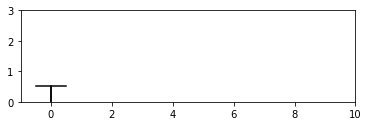

In [73]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')



def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,10])
    ax.set_ylim([0,3])
    
    #plot body
    body_xb = m.q[i,'x'].value - 0.5*m.len[('body',1)]*cos(m.q[i,'theta_b'].value)
    body_yb = m.q[i,'y'].value - 0.5*m.len[('body',1)]*sin(m.q[i,'theta_b'].value)
    body_xf = m.q[i,'x'].value + 0.5*m.len[('body',1)]*cos(m.q[i,'theta_b'].value)
    body_yf = m.q[i,'y'].value + 0.5*m.len[('body',1)]*sin(m.q[i,'theta_b'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black')
      
    #plot leg 1
    thA = m.q[i,'theta_b'].value+m.q[i,'theta_l'].value
    leg1_xt = m.q[i,'x'].value
    leg1_yt = m.q[i,'y'].value
    leg1_xb = m.q[i,'x'].value + m.len[('leg',1)]*sin(thA)
    leg1_yb = m.q[i,'y'].value - m.len[('leg',1)]*cos(thA)
    ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='xkcd:black')
    
    #plot leg 2
    Lt = 0.5*m.len[('leg',1)] + m.q[i,'r'].value - 0.5*m.len[('leg',2)]
    Lb = 0.5*m.len[('leg',1)] + m.q[i,'r'].value + 0.5*m.len[('leg',2)]
    leg2_xt = m.q[i,'x'].value + Lt*sin(thA)
    leg2_yt = m.q[i,'y'].value - Lt*cos(thA)
    leg2_xb = m.q[i,'x'].value + Lb*sin(thA)
    leg2_yb = m.q[i,'y'].value - Lb*cos(thA)
    ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='xkcd:black')

update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

In [37]:
# HIGH DROP -----------------------------------------------------------------------------------------------------------------

# initial condition
m.q[1,'x'].value = 0.0
m.q[1,'y'].value = 3.0
m.q[1,'theta_b'].value = 0.0
m.q[1,'theta_l'].value = 0.0
m.q[1,'r'].value = 0.25

for dof in DOFs:
    m.q[1,dof].fixed = True
    m.dq[1,dof].value = 0.0
    m.dq[1,dof].fixed = True
    
for n in range(1,N+1):
    m.F_a[n].value = 0.0
    m.F_a[n].fixed = True
    m.tau_a[n].value = 0.0
    m.tau_a[n].fixed = True
    
m.pprint()


23 Set Declarations
    DOF : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'x', 'y', 'theta_b', 'theta_l', 'r'}
    F_r_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :  N*sgn :  200 : {(1, 'ps'), (1, 'ng'), (2, 'ps'), (2, 'ng'), (3, 'ps'), (3, 'ng'), (4, 'ps'), (4, 'ng'), (5, 'ps'), (5, 'ng'), (6, 'ps'), (6, 'ng'), (7, 'ps'), (7, 'ng'), (8, 'ps'), (8, 'ng'), (9, 'ps'), (9, 'ng'), (10, 'ps'), (10, 'ng'), (11, 'ps'), (11, 'ng'), (12, 'ps'), (12, 'ng'), (13, 'ps'), (13, 'ng'), (14, 'ps'), (14, 'ng'), (15, 'ps'), (15, 'ng'), (16, 'ps'), (16, 'ng'), (17, 'ps'), (17, 'ng'), (18, 'ps'), (18, 'ng'), (19, 'ps'), (19, 'ng'), (20, 'ps'), (20, 'ng'), (21, 'ps'), (21, 'ng'), (22, 'ps'), (22, 'ng'), (23, 'ps'), (23, 'ng'), (24, 'ps'), (24, 'ng'), (25, 'ps'), (25, 'ng'), (26, 'ps'), (26, 'ng'), (27, 'ps'), (27, 'ng'), (28, 'ps'), (28, 'ng'), (29, 'ps'), (29, '

              (1, 'X') :   0.0 :                  None :  None : False :  True :  Reals
              (1, 'Y') :   0.0 :                   0.0 :  None :  True :  True :  Reals
          (2, 'THETA') :   0.0 :                  None :  None : False :  True :  Reals
              (2, 'X') :   0.0 :                  None :  None : False :  True :  Reals
              (2, 'Y') :   0.0 :   0.01230756771185425 :  None : False : False :  Reals
          (3, 'THETA') :   0.0 :                  None :  None : False :  True :  Reals
              (3, 'X') :   0.0 :                  None :  None : False :  True :  Reals
              (3, 'Y') :   0.0 :  0.011843673823522426 :  None : False : False :  Reals
          (4, 'THETA') :   0.0 :                  None :  None : False :  True :  Reals
              (4, 'X') :   0.0 :                  None :  None : False :  True :  Reals
              (4, 'Y') :   0.0 :                   0.0 :  None : False : False :  Reals
          (5, 'THETA') :   0.0 :

               (85, 'r') :                 0.0 :      0.2762410766181457 :                0.5 : False : False :  Reals
         (85, 'theta_b') :                None :      0.5209140165725583 :               None : False : False :  Reals
         (85, 'theta_l') : -1.5707963267948966 :       -0.86445997192586 : 1.5707963267948966 : False : False :  Reals
               (85, 'x') :                None :      3.9366352934613085 :               None : False : False :  Reals
               (85, 'y') :                 0.0 :      0.8871550538209122 :               None : False : False :  Reals
               (86, 'r') :                 0.0 :     0.21961517633028935 :                0.5 : False : False :  Reals
         (86, 'theta_b') :                None :     0.48434264503405017 :               None : False : False :  Reals
         (86, 'theta_l') : -1.5707963267948966 :       -0.76873765803554 : 1.5707963267948966 : False : False :  Reals
               (86, 'x') :                None :

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             : Upper : Active
          1 :   0.0 :                                                             -0.625*dq[1,theta_l]**2 - 1.25*dq[1,theta_l]*dq[1,theta_b] - 0.625*dq[1,theta_b]**2 - 2.5*dq[1,theta_l]**2*q[1,r] - 5.0*dq[1,theta_l]*dq[1,theta_b]*q[1,r] - 2.5*dq[1,theta_b]**2*q[1,r] - 2.5*ddq[1,y]*cos(q[1,theta_l] + q[1,theta_b]) + 2.5*ddq[1,x]*sin(q[1,theta_l] + q[1

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

        Key        : Lower : Body                                                                                                                                                                                                                                             : Upper : Active
          (1, 'X') :   0.0 :                             footv[1,X,ps] - footv[1,X,ng] - (dq[1,x] + dq[1,r]*sin(q[1,theta_l] + q[1,theta_b]) + dq[1,theta_l]*(0.5 + q[1,r])*cos(q[1,theta_l] + q[1,theta_b]) + dq[1,theta_b]*(0.5 + q[1,r])*cos(q[1,theta_l] + q[1,theta_b])) :   0.0 :   True
          (2, 'X') :   0.0 :                             footv[2,X,ps] - footv[2,X,ng] - (dq[2,x] + dq[2,r]*sin(q[2,theta_l] + q[2,theta_b]) + dq[2,theta_l]*(0.5 + q[2,r])*cos(q[2,theta_l] + q[2,theta_b]) + dq[2,theta_b]*(0.5 + q[2,r])*cos(q[2,theta_l] + q[2,theta_b])) :   0.0 :   True
          (3, 'X') :   0.0 :                             footv[3,X,ps] - footv[3,X,ng] - (dq[3,x] + dq[3,r]*sin(q[3,theta_l] + q[3,theta_b]

        Key : Lower : Body                                                        : Upper : Active
          1 :   0.0 :       ground_penalty[1,slip_ps] - footv[1,X,ps]*GRF[1,X,ps] :   0.0 :   True
          2 :   0.0 :       ground_penalty[2,slip_ps] - footv[2,X,ps]*GRF[2,X,ps] :   0.0 :   True
          3 :   0.0 :       ground_penalty[3,slip_ps] - footv[3,X,ps]*GRF[3,X,ps] :   0.0 :   True
          4 :   0.0 :       ground_penalty[4,slip_ps] - footv[4,X,ps]*GRF[4,X,ps] :   0.0 :   True
          5 :   0.0 :       ground_penalty[5,slip_ps] - footv[5,X,ps]*GRF[5,X,ps] :   0.0 :   True
          6 :   0.0 :       ground_penalty[6,slip_ps] - footv[6,X,ps]*GRF[6,X,ps] :   0.0 :   True
          7 :   0.0 :       ground_penalty[7,slip_ps] - footv[7,X,ps]*GRF[7,X,ps] :   0.0 :   True
          8 :   0.0 :       ground_penalty[8,slip_ps] - footv[8,X,ps]*GRF[8,X,ps] :   0.0 :   True
          9 :   0.0 :       ground_penalty[9,slip_ps] - footv[9,X,ps]*GRF[9,X,ps] :   0.0 :   True
         1

        Key              : Lower : Body                                                           : Upper : Active
                (2, 'r') :   0.0 :                          q[2,r] - (q[1,r] + 0.02*h[2]*dq[2,r]) :   0.0 :   True
          (2, 'theta_b') :   0.0 :        q[2,theta_b] - (q[1,theta_b] + 0.02*h[2]*dq[2,theta_b]) :   0.0 :   True
          (2, 'theta_l') :   0.0 :        q[2,theta_l] - (q[1,theta_l] + 0.02*h[2]*dq[2,theta_l]) :   0.0 :   True
                (2, 'x') :   0.0 :                          q[2,x] - (q[1,x] + 0.02*h[2]*dq[2,x]) :   0.0 :   True
                (2, 'y') :   0.0 :                          q[2,y] - (q[1,y] + 0.02*h[2]*dq[2,y]) :   0.0 :   True
                (3, 'r') :   0.0 :                          q[3,r] - (q[2,r] + 0.02*h[3]*dq[3,r]) :   0.0 :   True
          (3, 'theta_b') :   0.0 :        q[3,theta_b] - (q[2,theta_b] + 0.02*h[3]*dq[3,theta_b]) :   0.0 :   True
          (3, 'theta_l') :   0.0 :        q[3,theta_l] - (q[2,theta_l] + 0.02*h[

        Key              : Lower : Body                                                             : Upper : Active
                (2, 'r') :   0.0 :                         dq[2,r] - (dq[1,r] + 0.02*h[2]*ddq[1,r]) :   0.0 :   True
          (2, 'theta_b') :   0.0 :       dq[2,theta_b] - (dq[1,theta_b] + 0.02*h[2]*ddq[1,theta_b]) :   0.0 :   True
          (2, 'theta_l') :   0.0 :       dq[2,theta_l] - (dq[1,theta_l] + 0.02*h[2]*ddq[1,theta_l]) :   0.0 :   True
                (2, 'x') :   0.0 :                         dq[2,x] - (dq[1,x] + 0.02*h[2]*ddq[1,x]) :   0.0 :   True
                (2, 'y') :   0.0 :                         dq[2,y] - (dq[1,y] + 0.02*h[2]*ddq[1,y]) :   0.0 :   True
                (3, 'r') :   0.0 :                         dq[3,r] - (dq[2,r] + 0.02*h[3]*ddq[2,r]) :   0.0 :   True
          (3, 'theta_b') :   0.0 :       dq[3,theta_b] - (dq[2,theta_b] + 0.02*h[3]*ddq[2,theta_b]) :   0.0 :   True
          (3, 'theta_l') :   0.0 :       dq[3,theta_l] - (dq[2,t

TypeError: must be real number, not NoneType

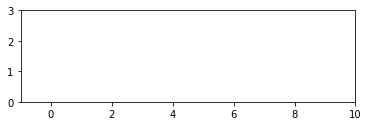

In [61]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')



def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,10])
    ax.set_ylim([0,3])
    


    
    #plot body
    body_xb = m.q[i,'x'].value - 0.5*m.len[('body',1)]*cos(m.q[i,'theta_b'].value)
    body_yb = m.q[i,'y'].value - 0.5*m.len[('body',1)]*sin(m.q[i,'theta_b'].value)
    body_xf = m.q[i,'x'].value + 0.5*m.len[('body',1)]*cos(m.q[i,'theta_b'].value)
    body_yf = m.q[i,'y'].value + 0.5*m.len[('body',1)]*sin(m.q[i,'theta_b'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black')
      
    #plot leg 1
    thA = m.q[i,'theta_b'].value+m.q[i,'theta_l'].value
    leg1_xt = m.q[i,'x'].value
    leg1_yt = m.q[i,'y'].value
    leg1_xb = m.q[i,'x'].value + m.len[('leg',1)]*sin(thA)
    leg1_yb = m.q[i,'y'].value - m.len[('leg',1)]*cos(thA)
    ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='xkcd:black')
    
    #plot leg 2
    Lt = 0.5*m.len[('leg',1)] + m.q[i,'r'].value - 0.5*m.len[('leg',2)]
    Lb = 0.5*m.len[('leg',1)] + m.q[i,'r'].value + 0.5*m.len[('leg',2)]
    leg2_xt = m.q[i,'x'].value + Lt*sin(thA)
    leg2_yt = m.q[i,'y'].value - Lt*cos(thA)
    leg2_xb = m.q[i,'x'].value + Lb*sin(thA)
    leg2_yb = m.q[i,'y'].value - Lb*cos(thA)
    ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='xkcd:black')

    
    
   
    
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook